Processed Data for 109554.json:     frame  ball_control  boost_value  shots_on_goal  saves
0  464000         False           76           True  False
1  476333          True           79          False  False
2  478666         False           71           True  False
3  481333          True           63          False  False
4  486333         False           61           True  False
Processed Data for 125752_rocket_league_postprocess.json:    frame  ball_control  boost_value  shots_on_goal  saves
0  46666         False            5           True   True
1  50333          True           12          False  False
2  61666         False            7           True   True
3  62666          True           86          False  False
4  63666         False           94           True  False
Processed Data for 130953.json:    frame  ball_control  boost_value  shots_on_goal  saves
0      0         False           27           True  False
1      0          True           16          False  False
2 

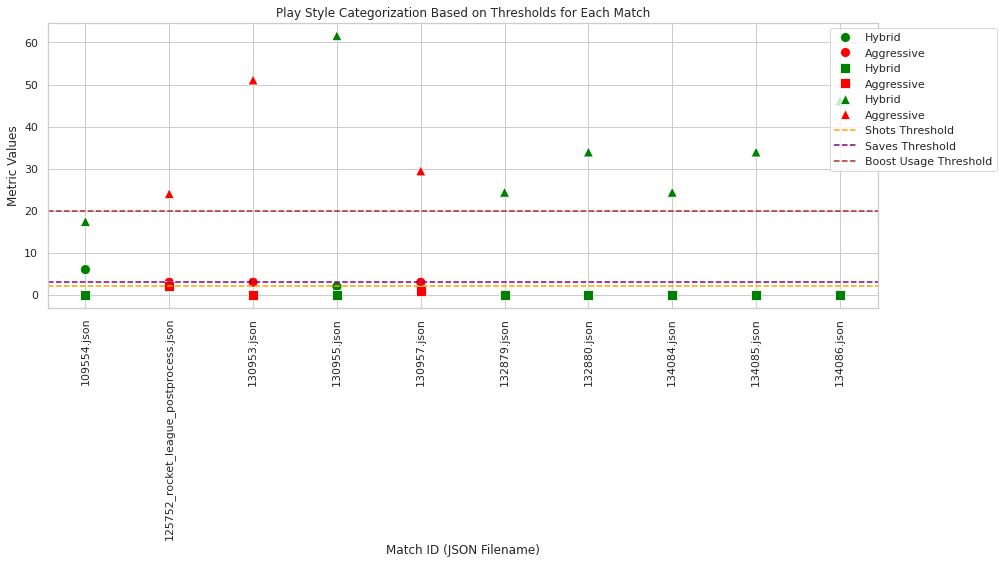

In [2]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
json_dir = "Data"  
SHOTS_THRESHOLD = 2
SAVES_THRESHOLD = 3
BOOST_USAGE_THRESHOLD = 20
palette = {"Aggressive": "red", "Defensive": "blue", "Hybrid": "green"}

def preprocess_game_data(data):
    frames = data.get('rounds', {}).get('0', {}).get('clock', [])
    ball_control = data.get('rounds', {}).get('0', {}).get('ball_control', [])
    boost_usage = data.get('rounds', {}).get('0', {}).get('boost_value', [])
    shots_on_goal = data.get('rounds', {}).get('0', {}).get('shots_on_goal', [])
    saves = data.get('rounds', {}).get('0', {}).get('saves', [])
    
    max_length = max(len(frames), len(ball_control), len(boost_usage), len(shots_on_goal), len(saves))
    
    def adjust_length(lst, fill_value):
        return lst + [fill_value] * (max_length - len(lst)) if len(lst) < max_length else lst
    
    frames = adjust_length(frames, [0, '0:00'])
    ball_control = adjust_length(ball_control, [0, False])
    boost_usage = adjust_length(boost_usage, [0, 0])
    shots_on_goal = adjust_length(shots_on_goal, [0, False])
    saves = adjust_length(saves, [0, False])
    df = pd.DataFrame({
        'frame': [f[0] for f in frames],
        'ball_control': [bc[1] for bc in ball_control],
        'boost_value': [b[1] for b in boost_usage],
        'shots_on_goal': [s[1] for s in shots_on_goal],
        'saves': [s[1] for s in saves]
    })
    return df
feature_datasets = []


for filename in os.listdir(json_dir):
    if filename.endswith(".json"):
        filepath = os.path.join(json_dir, filename)
        with open(filepath, 'r') as file:
            data = json.load(file)
            # Process individual JSON data
            processed_data = preprocess_game_data(data)
            print(f"Processed Data for {filename}:", processed_data.head())
            
            features = {
                'avg_ball_control': np.mean(processed_data['ball_control']),
                'avg_boost_usage': np.mean(processed_data['boost_value']),
                'shots_on_goal': processed_data['shots_on_goal'].sum(),
                'saves': processed_data['saves'].sum(),
                'file_name': filename
            }
            if features['shots_on_goal'] > SHOTS_THRESHOLD and features['avg_boost_usage'] > BOOST_USAGE_THRESHOLD:
                features['play_style'] = 'Aggressive'
            elif features['saves'] > SAVES_THRESHOLD and features['avg_boost_usage'] < BOOST_USAGE_THRESHOLD:
                features['play_style'] = 'Defensive'
            else:
                features['play_style'] = 'Hybrid'
            
            feature_datasets.append(features)
final_dataset = pd.DataFrame(feature_datasets)
print("Final Dataset with Play Styles and Encoded Labels:", final_dataset.head())
plt.figure(figsize=(14, 8))
sns.scatterplot(
    x=final_dataset['file_name'],
    y=final_dataset['shots_on_goal'],
    hue=final_dataset['play_style'],
    palette=palette,
    s=100 
)

sns.scatterplot(
    x=final_dataset['file_name'],
    y=final_dataset['saves'],
    hue=final_dataset['play_style'],
    palette=palette,
    s=100,
    marker='s'  
)

sns.scatterplot(
    x=final_dataset['file_name'],
    y=final_dataset['avg_boost_usage'],
    hue=final_dataset['play_style'],
    palette=palette,
    s=100,
    marker='^'  
)
plt.axhline(SHOTS_THRESHOLD, color="orange", linestyle="--", label="Shots Threshold")
plt.axhline(SAVES_THRESHOLD, color="purple", linestyle="--", label="Saves Threshold")
plt.axhline(BOOST_USAGE_THRESHOLD, color="brown", linestyle="--", label="Boost Usage Threshold")

plt.xlabel("Match ID (JSON Filename)")
plt.ylabel("Metric Values")
plt.title("Play Style Categorization Based on Thresholds for Each Match")
plt.legend(loc="upper right", bbox_to_anchor=(1.15, 1))  

plt.xticks(rotation=90)
plt.tight_layout()  
plt.show()


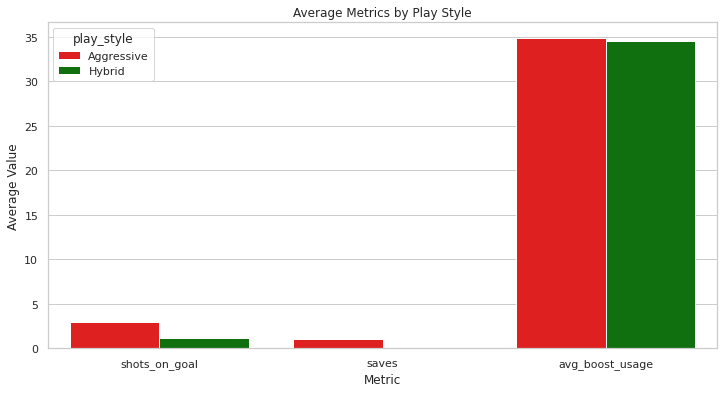

In [4]:

#Bar Plot for Average Metric Comparison

avg_metrics = final_dataset.groupby('play_style').mean()[['shots_on_goal', 'saves', 'avg_boost_usage']].reset_index()
avg_metrics_melted = avg_metrics.melt(id_vars='play_style', var_name='Metric', value_name='Average Value')

plt.figure(figsize=(12, 6))
sns.barplot(x='Metric', y='Average Value', hue='play_style', data=avg_metrics_melted, palette=palette)
plt.title("Average Metrics by Play Style")
plt.xlabel("Metric")
plt.ylabel("Average Value")
plt.show()


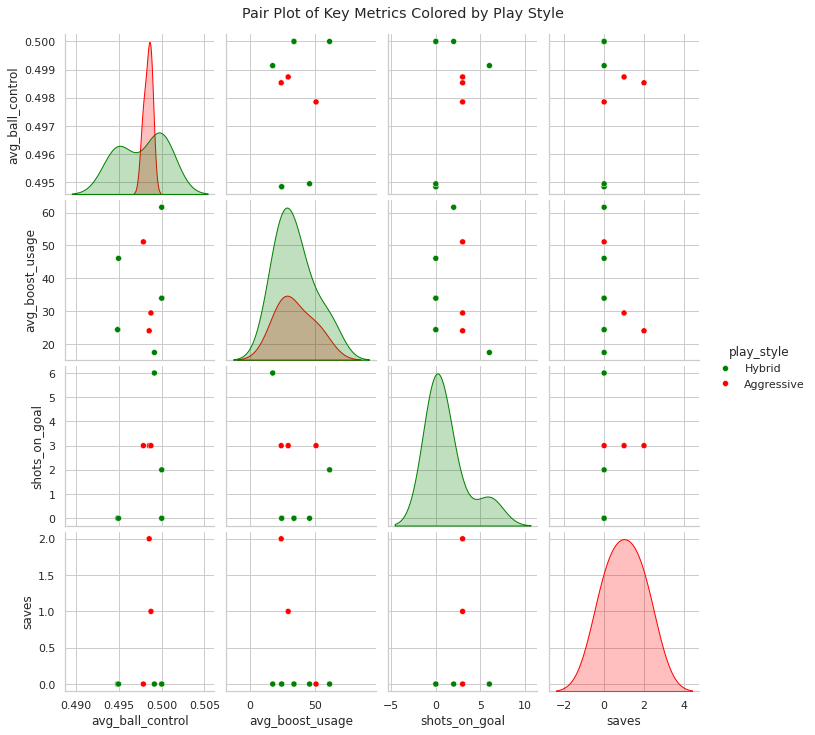

In [7]:

#Pair-Plot for feature relationships

sns.pairplot(final_dataset, hue='play_style', palette=palette, diag_kind='kde')
plt.suptitle("Pair Plot of Key Metrics Colored by Play Style", y=1.02)
plt.show()


Processed Data for 109554.json:     frame  ball_control  boost_value
0  464000         False           76
1  476333          True           79
2  478666         False           71
3  481333          True           63
4  486333         False           61
Processed Data for 125752_rocket_league_postprocess.json:    frame  ball_control  boost_value
0  46666         False            5
1  50333          True           12
2  61666         False            7
3  62666          True           86
4  63666         False           94
Processed Data for 130953.json:    frame  ball_control  boost_value
0      0         False           27
1      0          True           16
2      0         False           88
3      0          True           78
4      0         False           75
Processed Data for 130955.json:     frame  ball_control  boost_value
0   77666         False           27
1  215333          True           31
2  216333         False           23
3       0          True           12
4      

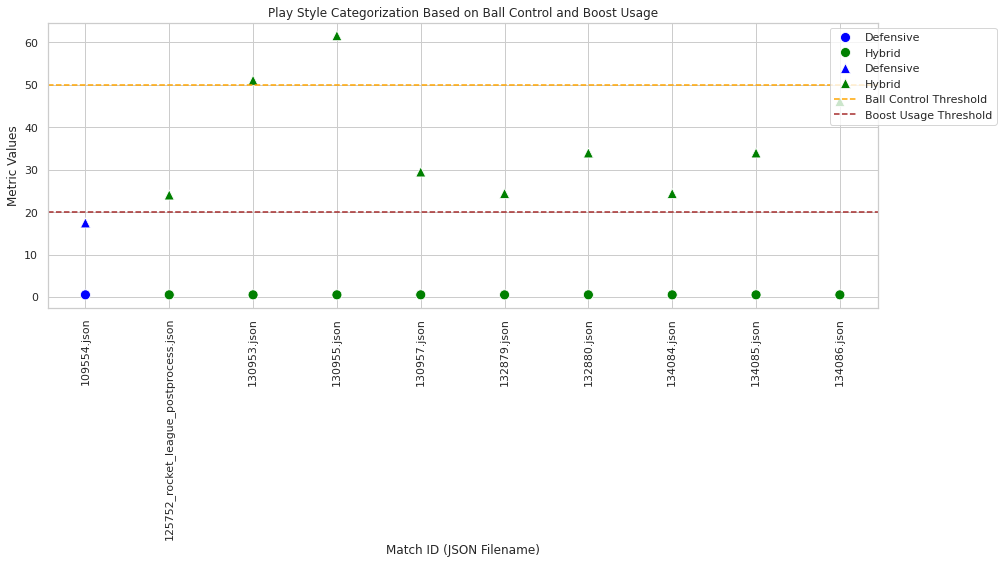

In [5]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
json_dir = "Data"  
BALL_CONTROL_THRESHOLD = 50  # Adjust this threshold as per requirements
BOOST_USAGE_THRESHOLD = 20
palette = {"Aggressive": "red", "Defensive": "blue", "Hybrid": "green"}

def preprocess_game_data(data):
    frames = data.get('rounds', {}).get('0', {}).get('clock', [])
    ball_control = data.get('rounds', {}).get('0', {}).get('ball_control', [])
    boost_usage = data.get('rounds', {}).get('0', {}).get('boost_value', [])
    
    max_length = max(len(frames), len(ball_control), len(boost_usage))
    
    def adjust_length(lst, fill_value):
        return lst + [fill_value] * (max_length - len(lst)) if len(lst) < max_length else lst
    
    frames = adjust_length(frames, [0, '0:00'])
    ball_control = adjust_length(ball_control, [0, False])
    boost_usage = adjust_length(boost_usage, [0, 0])
    
    df = pd.DataFrame({
        'frame': [f[0] for f in frames],
        'ball_control': [bc[1] for bc in ball_control],
        'boost_value': [b[1] for b in boost_usage]
    })
    return df

feature_datasets = []

for filename in os.listdir(json_dir):
    if filename.endswith(".json"):
        filepath = os.path.join(json_dir, filename)
        with open(filepath, 'r') as file:
            data = json.load(file)
            processed_data = preprocess_game_data(data)
            print(f"Processed Data for {filename}:", processed_data.head())
            
            features = {
                'avg_ball_control': np.mean(processed_data['ball_control']),
                'avg_boost_usage': np.mean(processed_data['boost_value']),
                'file_name': filename
            }
            
            # Determine play style based on ball control and boost usage thresholds
            if features['avg_ball_control'] > BALL_CONTROL_THRESHOLD and features['avg_boost_usage'] > BOOST_USAGE_THRESHOLD:
                features['play_style'] = 'Aggressive'
            elif features['avg_ball_control'] < BALL_CONTROL_THRESHOLD and features['avg_boost_usage'] < BOOST_USAGE_THRESHOLD:
                features['play_style'] = 'Defensive'
            else:
                features['play_style'] = 'Hybrid'
            
            feature_datasets.append(features)

final_dataset = pd.DataFrame(feature_datasets)
print("Final Dataset with Play Styles and Encoded Labels:", final_dataset.head())

plt.figure(figsize=(14, 8))

sns.scatterplot(
    x=final_dataset['file_name'],
    y=final_dataset['avg_ball_control'],
    hue=final_dataset['play_style'],
    palette=palette,
    s=100 
)

sns.scatterplot(
    x=final_dataset['file_name'],
    y=final_dataset['avg_boost_usage'],
    hue=final_dataset['play_style'],
    palette=palette,
    s=100,
    marker='^'  
)

plt.axhline(BALL_CONTROL_THRESHOLD, color="orange", linestyle="--", label="Ball Control Threshold")
plt.axhline(BOOST_USAGE_THRESHOLD, color="brown", linestyle="--", label="Boost Usage Threshold")

plt.xlabel("Match ID (JSON Filename)")
plt.ylabel("Metric Values")
plt.title("Play Style Categorization Based on Ball Control and Boost Usage")
plt.legend(loc="upper right", bbox_to_anchor=(1.15, 1))  

plt.xticks(rotation=90)
plt.tight_layout()  
plt.show()


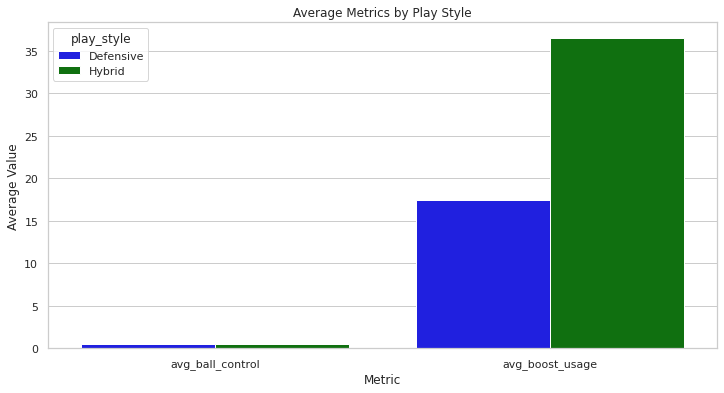

In [6]:

#Bar Plot for Average Metric Comparison

avg_metrics = final_dataset.groupby('play_style').mean()[['avg_ball_control', 'avg_boost_usage']].reset_index()
avg_metrics_melted = avg_metrics.melt(id_vars='play_style', var_name='Metric', value_name='Average Value')

plt.figure(figsize=(12, 6))
sns.barplot(x='Metric', y='Average Value', hue='play_style', data=avg_metrics_melted, palette=palette)
plt.title("Average Metrics by Play Style")
plt.xlabel("Metric")
plt.ylabel("Average Value")
plt.show()


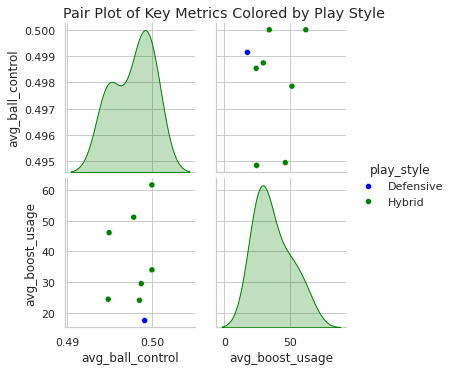

In [7]:

#Pair-Plot for feature relationships

sns.pairplot(final_dataset, hue='play_style', palette=palette, diag_kind='kde')
plt.suptitle("Pair Plot of Key Metrics Colored by Play Style", y=1.02)
plt.show()
